In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Thu Nov 24 14:59:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0    46W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import os
import tensorflow_hub as hub
import keras

SEED = 0

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

set_global_determinism(seed=SEED) # Setting seed for a reproducible code.
print(f'Tensorflow Version: {tf.__version__}')

Tensorflow Version: 2.9.2


In [ ]:
df = np.load('/content/drive/MyDrive/Colab Notebooks/Avaliação - Deep Learning/df224_[0-1].npz')
imagens, rotulos = df['x'], df['y']
rotulos.shape
print("rotulos shape: ", rotulos.shape)
print("rotulos size: ", rotulos.size)
print("rotulos type: ", type(rotulos))

rotulos shape:  (2193,)
rotulos size:  2193
rotulos type:  <class 'numpy.ndarray'>


In [ ]:
imagens.shape
print("imagens shape: ", imagens.shape)
print("imagens size: ", imagens.size)
print("imagens type: ", type(imagens))

imagens shape:  (2193, 224, 224, 3)
imagens size:  330107904
imagens type:  <class 'numpy.ndarray'>


In [ ]:
imagens_data = imagens.reshape(imagens.shape[0], imagens.shape[1] * imagens.shape[2] * imagens.shape[3])

In [ ]:
n_amostra = imagens.shape[0]
n_pixels = imagens_data.shape[1]
n_classes = len(np.unique(rotulos))

print("Informações do dataset\n")
print(f"Nº de amostras: {n_amostra}")
print(f"tamanho das imagens: {imagens.shape[1]} x {imagens.shape[2]}")
print(f"Nº de pixels por imagem: {n_pixels}")
print(f"Nº de classes: {n_classes}" )
print("rotulos únicos:",np.unique(rotulos))

Informações do dataset

Nº de amostras: 2193
tamanho das imagens: 224 x 224
Nº de pixels por imagem: 150528
Nº de classes: 2
rotulos únicos: [0 1]


In [ ]:
def plot_imagens(imagens, ids_unicos, n_amostras_por_id = 1100):
    """
    Plota uma imagem de cada rotulo do dataset.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    LABELS = ['No Findings', 'Cardiomegaly'] 
    fig, axarr = plt.subplots(nrows=1, ncols=len(np.unique(rotulos)), figsize=(15, 5))
    axarr = axarr.flatten()

    for ids_unicos in np.unique(rotulos):
        image_index = ids_unicos*n_amostras_por_id
        axarr[ids_unicos].imshow(imagens[image_index], cmap='gray')
        axarr[ids_unicos].set_xticks([])
        axarr[ids_unicos].set_yticks([])
        axarr[ids_unicos].set_title(f"{LABELS[ids_unicos]}")
    #plt.suptitle(f"Nós temos {len(np.unique(rotulos))} diagnosticos distintos no dataset:")

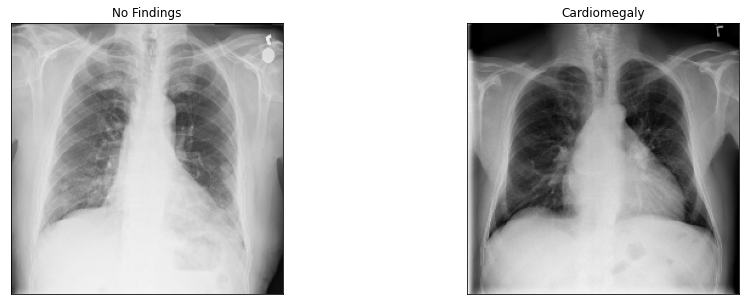

In [ ]:
plot_imagens(imagens, np.unique(rotulos))

In [ ]:
# Dividindo a base em treinamento e validação com uso da biblioteca SciKit Learn.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['x'], df['y'], test_size=0.20, random_state=SEED)

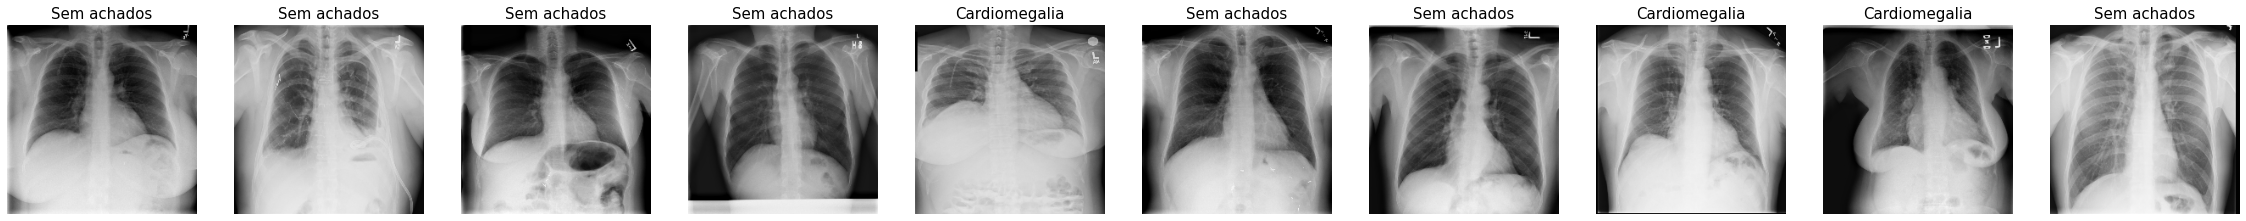

In [ ]:
# Plotando 10 imagens da base de treinamento
import matplotlib.pyplot as plt
plt.figure(figsize=(40,40))

num_images = 10
for i in range(num_images):
    row = X_train[i]
    label = y_train[i]
    LABELS = ['Sem achados', 'Cardiomegalia']

    image = row.reshape(224,224,3)
    plt.subplot(1, num_images, i+1)
    plt.title(LABELS[label], fontdict={'fontsize': 15})
    plt.axis('off')
    plt.imshow(image, cmap='gray')

In [ ]:
test_nf = np.count_nonzero(y_test == 0)
test_cm = np.count_nonzero(y_test == 1)
train_nf = np.count_nonzero(y_train == 0)
train_cm = np.count_nonzero(y_train == 1)

print(f"""
{20*'='}
Label Distribution
{20*'='}
\n
> Train:
Total: {train_cm + train_nf}
No Findings: {train_nf} ~ {train_nf/(train_nf + train_cm)*100:.4f}%
Cardiomegaly: {train_cm} ~ {train_cm/(train_nf + train_cm)*100:.4f}%
\n
> Test:
Total: {test_cm + test_nf}
No Findings: {test_nf} ~ {test_nf/(test_nf + test_cm)*100:.4f}%
Cardiomegaly: {test_cm} ~ {test_cm/(test_nf + test_cm)*100:.4f}%
""")

del(test_nf, test_cm, train_cm, train_nf)


Label Distribution


> Train:
Total: 1754
No Findings: 875 ~ 49.8860%
Cardiomegaly: 879 ~ 50.1140%


> Test:
Total: 439
No Findings: 225 ~ 51.2528%
Cardiomegaly: 214 ~ 48.7472%



## Warm-up + [cosine | linear] LR


In [ ]:
num_classes = 2
EPOCHS = 100
BATCH_SIZE = 32
# AUTO = tf.data.AUTOTUNE

In [ ]:
# Learning rate scheduling (warm-up + [cosine | linear])
## Reference: https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2


class WarmUpCosine(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")
        learning_rate = (
            0.5
            * self.learning_rate_base
            * (
                1
                + tf.cos(
                    self.pi
                    * (tf.cast(step, tf.float32) - self.warmup_steps)
                    / float(self.total_steps - self.warmup_steps)
                )
            )
        )

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )

In [ ]:
num_train = len(X_train)
num_test = len(X_test)

In [ ]:
TOTAL_STEPS = int((num_train / BATCH_SIZE) * EPOCHS)
WARMUP_STEPS = 10
INIT_LR = 0.03
WAMRUP_LR = 0.006

print(TOTAL_STEPS)

5481


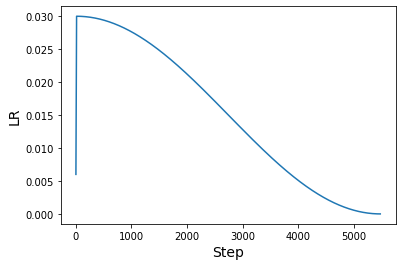

In [ ]:
scheduled_lrs = WarmUpCosine(
    learning_rate_base=INIT_LR,
    total_steps=TOTAL_STEPS,
    warmup_learning_rate=WAMRUP_LR,
    warmup_steps=WARMUP_STEPS,
)

lrs = [scheduled_lrs(step) for step in range(TOTAL_STEPS)]
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

In [ ]:
optimizer = keras.optimizers.SGD(scheduled_lrs, clipnorm=1.0)
loss = keras.losses.SparseCategoricalCrossentropy()
initializer = keras.initializers.HeNormal(SEED)

## MLP Approach

In [ ]:
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Criando uma MLP de com 2 Dense de 512 neuronios e uma saida com ativação Softmax
# Camada Flatten de entrada adicionada apenas para transformar a imagem em um array sem editar a base que será usada também para a abordagem de DL

model_mlp = keras.Sequential()
model_mlp.add(Flatten(input_shape=(224,224,3))) ## Transformar a imagem em uma sequência de pixels
model_mlp.add(Dense(512, activation="relu", kernel_initializer = initializer))
model_mlp.add(keras.layers.Dropout(0.5))
model_mlp.add(Dense(512, activation="relu", kernel_initializer = initializer))
model_mlp.add(keras.layers.Dropout(0.5))
model_mlp.add(Dense(num_classes, activation="softmax"))

In [ ]:
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 512)               77070848  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 77,334,530
Trainable params: 77,334,530
No

In [ ]:
# Como teremos apenas duas categorias, o indicado é utilizar sparse_categorical_crossentropy como loss function 
model_mlp.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])

In [ ]:
# Retornaremos o melhor conjunto de pesos que maximize a acurácia do modelo nos dados de validação
callback_parada = EarlyStopping(monitor='val_accuracy',
                                min_delta = 0.001,
                                patience = 20,
                                verbose = True,
                                mode='max',
                                baseline = None,
                                restore_best_weights=True)

In [ ]:
t0 = time.time()
history_mlp = model_mlp.fit(X_train,
                            y_train,
                            batch_size=BATCH_SIZE,
                            epochs=EPOCHS,
                            validation_data=(X_test, y_test),
                            callbacks=[callback_parada])
print("Training time:", time.time()-t0)

Epoch 1/100
55/55 [==============================] - 3s 29ms/step - loss: 0.9708 - accuracy: 0.5051 - val_loss: 0.6940 - val_accuracy: 0.5171
Epoch 2/100
55/55 [==============================] - 1s 15ms/step - loss: 0.7471 - accuracy: 0.5125 - val_loss: 0.6942 - val_accuracy: 0.4715
Epoch 3/100
55/55 [==============================] - 1s 15ms/step - loss: 0.7100 - accuracy: 0.4977 - val_loss: 0.6907 - val_accuracy: 0.5125
Epoch 4/100
55/55 [==============================] - 1s 15ms/step - loss: 0.7061 - accuracy: 0.4943 - val_loss: 0.6935 - val_accuracy: 0.4875
Epoch 5/100
55/55 [==============================] - 1s 16ms/step - loss: 0.6991 - accuracy: 0.4880 - val_loss: 0.7239 - val_accuracy: 0.4875
Epoch 6/100
55/55 [==============================] - 1s 19ms/step - loss: 0.6985 - accuracy: 0.4966 - val_loss: 0.6930 - val_accuracy: 0.5262
Epoch 7/100
55/55 [==============================] - 1s 15ms/step - loss: 0.6941 - accuracy: 0.4960 - val_loss: 0.6930 - val_accuracy: 0.5148
Epoch 

In [ ]:
def plotHistory(history, patience):
  import matplotlib.pyplot as plt

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.plot([history.epoch[-1]-int(patience),history.epoch[-1]-int(patience)],
            plt.ylim(), label='Best Epoch')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.plot([history.epoch[-1]-int(patience),history.epoch[-1]-int(patience)],
            plt.ylim(), label='Best Epoch')
  plt.legend(loc='upper right')
  plt.ylabel('Sparse Categorical Cross Entropy')
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

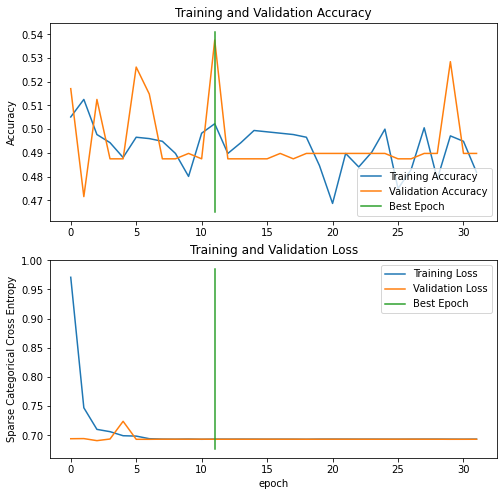

In [ ]:
plotHistory(history_mlp, 20)

14/14 [==============================] - 0s 9ms/step
Prediction time: 0.4651656150817871

The average accuracy of the exploring model on Test Data is: 53.7585%


[Text(33.0, 0.5, 'True Label'), Text(0.5, 15.0, 'Predicted Label')]

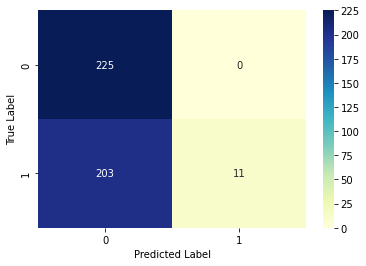

In [ ]:
t0 = time.time()
pred_mlp = model_mlp.predict(X_test)
print("Prediction time:", time.time()-t0)
y_pred_mlp = np.argmax(pred_mlp, axis=1)

print(f'\nThe average accuracy of the exploring model on Test Data is: {accuracy_score(y_pred_mlp, y_test)*100:.4f}%')
hm = sns.heatmap(confusion_matrix(y_test, y_pred_mlp), annot=True, fmt='g', cmap="YlGnBu")
hm.set(xlabel="Predicted Label", ylabel="True Label")

## CNN approach

In [ ]:
base_model = keras.applications.VGG16(
    weights="imagenet",  # Load weights pre-trained on ImageNet 1k.
    input_shape=(224, 224, 3),
    include_top=False)

base_model.trainable = False # Freeze base model


58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
inputs = keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)

# Add pooling layer or flatten layer
x = keras.layers.Flatten()(x)
# x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512, activation = 'relu', kernel_initializer = initializer)(x)

# Dropout for regularization and overfit prevention
x = keras.layers.Dropout(0.5)(x)

# Add final dense layer
outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

# Combine inputs and outputs to create model
model_cnn = keras.Model(inputs, outputs)

In [ ]:
model_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 27,561,282
Trainable params: 12,846,594
Non-tra

In [ ]:
model_cnn.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])

t0 = time.time()
history_cnn = model_cnn.fit(X_train,
                        y_train,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        validation_data=(X_test, y_test),
                        callbacks=[callback_parada])
print("Training time:", time.time()-t0)

Epoch 1/100
55/55 [==============================] - 14s 65ms/step - loss: 0.8614 - accuracy: 0.5143 - val_loss: 0.7564 - val_accuracy: 0.5125
Epoch 2/100
55/55 [==============================] - 2s 37ms/step - loss: 0.7278 - accuracy: 0.5234 - val_loss: 0.7184 - val_accuracy: 0.4875
Epoch 3/100
55/55 [==============================] - 2s 38ms/step - loss: 0.7156 - accuracy: 0.5097 - val_loss: 0.6639 - val_accuracy: 0.6788
Epoch 4/100
55/55 [==============================] - 2s 37ms/step - loss: 0.6928 - accuracy: 0.5576 - val_loss: 0.6555 - val_accuracy: 0.5991
Epoch 5/100
55/55 [==============================] - 2s 36ms/step - loss: 0.6773 - accuracy: 0.5804 - val_loss: 0.7091 - val_accuracy: 0.4966
Epoch 6/100
55/55 [==============================] - 2s 36ms/step - loss: 0.6797 - accuracy: 0.5741 - val_loss: 0.6435 - val_accuracy: 0.5649
Epoch 7/100
55/55 [==============================] - 2s 36ms/step - loss: 0.6576 - accuracy: 0.5975 - val_loss: 0.6366 - val_accuracy: 0.6310
Epoch

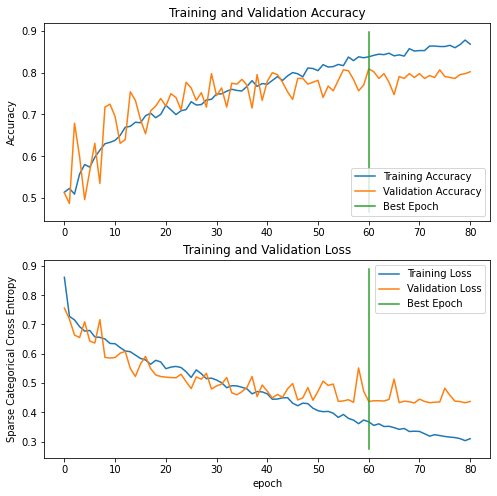

In [ ]:
plotHistory(history_cnn, 20)

14/14 [==============================] - 1s 27ms/step
Prediction time: 0.8157026767730713

The average accuracy of the exploring model on Test Data is: 80.8656%


[Text(33.0, 0.5, 'True Label'), Text(0.5, 15.0, 'Predicted Label')]

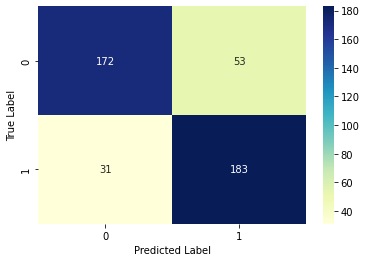

In [ ]:
t0 = time.time()
pred_cnn = model_cnn.predict(X_test)
print("Prediction time:", time.time()-t0)
y_pred_cnn = np.argmax(pred_cnn, axis=1)

print(f'\nThe average accuracy of the exploring model on Test Data is: {accuracy_score(y_pred_cnn, y_test)*100:.4f}%')
hm = sns.heatmap(confusion_matrix(y_test, y_pred_cnn), annot=True, fmt='g', cmap="YlGnBu")
hm.set(xlabel="Predicted Label", ylabel="True Label")

In [ ]:
# Fine Tunning
base_model.trainable = True

model_cnn.compile(optimizer=keras.optimizers.RMSprop(learning_rate = .00001),
                  loss=loss,
                  metrics=["accuracy"])

In [ ]:
t0 = time.time()
history_cnn_ft = model_cnn.fit(X_train,
                            y_train,
                            batch_size=BATCH_SIZE,
                            epochs=EPOCHS,
                            validation_data=(X_test, y_test),
                            callbacks=[callback_parada])
print("Fine Tunning time:", time.time()-t0)

Epoch 1/100
55/55 [==============================] - 9s 98ms/step - loss: 0.4718 - accuracy: 0.7993 - val_loss: 0.6387 - val_accuracy: 0.6993
Epoch 2/100
55/55 [==============================] - 4s 79ms/step - loss: 0.3410 - accuracy: 0.8529 - val_loss: 0.4847 - val_accuracy: 0.7722
Epoch 3/100
55/55 [==============================] - 4s 79ms/step - loss: 0.3035 - accuracy: 0.8706 - val_loss: 0.4238 - val_accuracy: 0.8109
Epoch 4/100
55/55 [==============================] - 4s 79ms/step - loss: 0.2515 - accuracy: 0.8922 - val_loss: 0.4028 - val_accuracy: 0.8132
Epoch 5/100
55/55 [==============================] - 4s 79ms/step - loss: 0.2111 - accuracy: 0.9179 - val_loss: 0.3976 - val_accuracy: 0.8223
Epoch 6/100
55/55 [==============================] - 4s 78ms/step - loss: 0.1790 - accuracy: 0.9344 - val_loss: 0.4178 - val_accuracy: 0.7904
Epoch 7/100
55/55 [==============================] - 4s 79ms/step - loss: 0.1470 - accuracy: 0.9504 - val_loss: 0.4073 - val_accuracy: 0.8337
Epoch 

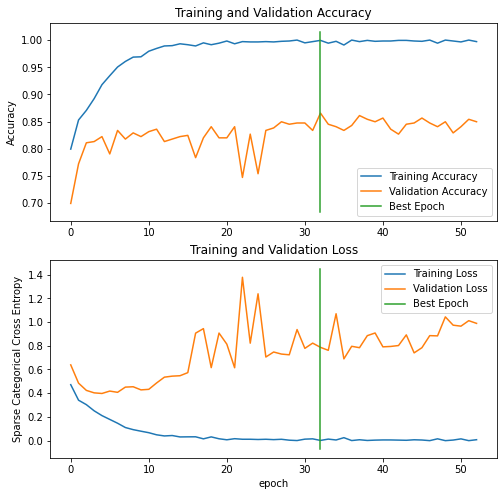

In [ ]:
plotHistory(history_cnn_ft, 20)

14/14 [==============================] - 1s 28ms/step
Prediction time: 0.7942030429840088

The average accuracy of the exploring model on Test Data is: 86.5604%


[Text(33.0, 0.5, 'True Label'), Text(0.5, 15.0, 'Predicted Label')]

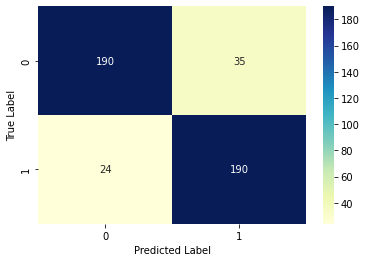

In [ ]:
t0 = time.time()
pred_cnn = model_cnn.predict(X_test)
print("Prediction time:", time.time()-t0)
y_pred_cnn = np.argmax(pred_cnn, axis=1)

print(f'\nThe average accuracy of the exploring model on Test Data is: {accuracy_score(y_pred_cnn, y_test)*100:.4f}%')
hm = sns.heatmap(confusion_matrix(y_test, y_pred_cnn), annot=True, fmt='g', cmap="YlGnBu")
hm.set(xlabel="Predicted Label", ylabel="True Label")

## VIT approach

In [ ]:
## Making tensor dataset to fit vit_L16_fe input shape

x_train = np.expand_dims(X_train, axis=-1)
x_test = np.expand_dims(X_test, axis=-1)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(SEED)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE).prefetch(SEED)

In [ ]:
import tensorflow_hub as hub

def get_model(
    handle="https://tfhub.dev/sayakpaul/vit_l16_fe/1", 
    num_classes=2,
):
    hub_layer = hub.KerasLayer(handle, trainable=False, name = 'vit_l16_fe')

    model = keras.Sequential(
        [
            keras.layers.InputLayer((224, 224, 3)),
            hub_layer,
            keras.layers.Dense(512, activation="relu", kernel_initializer = initializer),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(num_classes, activation="softmax")
            
        ]
    )
    return model

model_ViT = get_model()
model_ViT.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit_l16_fe (KerasLayer)     (None, 1024)              303301632 
                                                                 
 dense_3 (Dense)             (None, 512)               524800    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 303,827,458
Trainable params: 525,826
Non-trainable params: 303,301,632
_________________________________________________________________


In [ ]:
model_ViT.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
t0 = time.time()
history_VIT = model_ViT.fit(train_dataset,
                    validation_data = test_dataset,
                    epochs=EPOCHS,
                    callbacks=[callback_parada])
print("Training time:", time.time()-t0)

Epoch 1/100
55/55 [==============================] - 63s 844ms/step - loss: 1.9846 - accuracy: 0.5296 - val_loss: 1.4068 - val_accuracy: 0.5216
Epoch 2/100
55/55 [==============================] - 19s 349ms/step - loss: 1.2039 - accuracy: 0.5485 - val_loss: 0.9454 - val_accuracy: 0.5467
Epoch 3/100
55/55 [==============================] - 19s 350ms/step - loss: 0.9127 - accuracy: 0.5821 - val_loss: 0.7890 - val_accuracy: 0.5672
Epoch 4/100
55/55 [==============================] - 19s 350ms/step - loss: 0.8293 - accuracy: 0.5821 - val_loss: 0.6996 - val_accuracy: 0.6241
Epoch 5/100
55/55 [==============================] - 19s 351ms/step - loss: 0.7566 - accuracy: 0.5872 - val_loss: 0.6214 - val_accuracy: 0.6720
Epoch 6/100
55/55 [==============================] - 18s 336ms/step - loss: 0.6992 - accuracy: 0.6277 - val_loss: 0.6826 - val_accuracy: 0.6082
Epoch 7/100
55/55 [==============================] - 19s 350ms/step - loss: 0.6661 - accuracy: 0.6363 - val_loss: 0.6131 - val_accuracy:

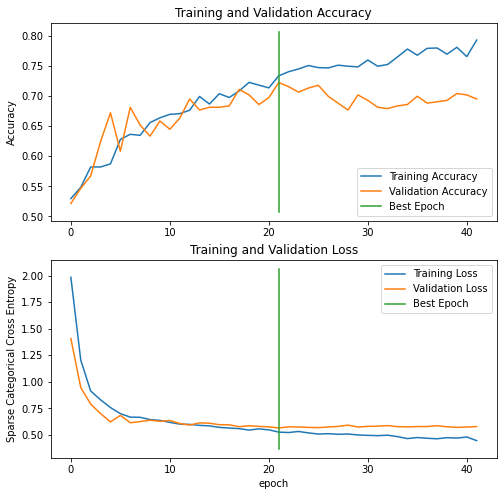

In [ ]:
plotHistory(history_VIT, 20)

14/14 [==============================] - 5s 266ms/step
Prediction time: 5.3439483642578125

The average accuracy of the exploring model on Test Data is: 72.2096%


[Text(33.0, 0.5, 'True Label'), Text(0.5, 15.0, 'Predicted Label')]

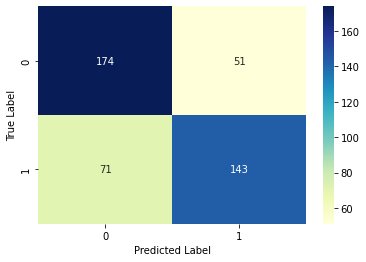

In [ ]:
t0 = time.time()
pred_ViT = model_ViT.predict(X_test)
print("Prediction time:", time.time()-t0)
y_pred_ViT = np.argmax(pred_ViT, axis=1)

print(f'\nThe average accuracy of the exploring model on Test Data is: {accuracy_score(y_pred_ViT, y_test)*100:.4f}%')
hm = sns.heatmap(confusion_matrix(y_test, y_pred_ViT), annot=True, fmt='g', cmap="YlGnBu")
hm.set(xlabel="Predicted Label", ylabel="True Label")

In [ ]:
!nvidia-smi

Thu Nov 24 13:15:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    69W / 400W |   9630MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------